
Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     21866
           1       0.76      0.39      0.52      1280

    accuracy                           0.96     23146
   macro avg       0.86      0.69      0.75     23146
weighted avg       0.95      0.96      0.95     23146



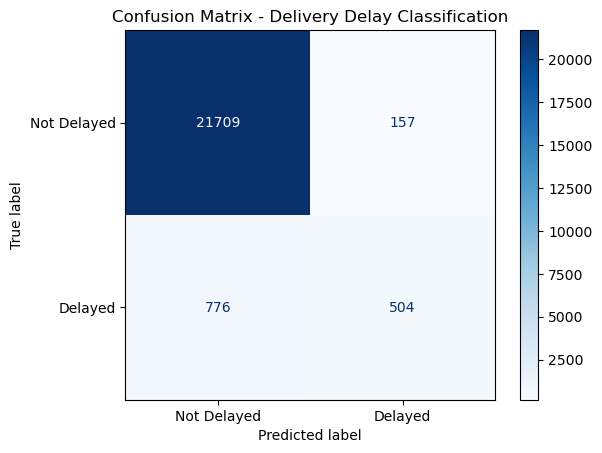


Model Coefficients:

         Feature  Coefficient
0  shipping_days     0.178491
1  freight_value    -0.019218
2          price     0.001019
3  payment_value    -0.000590


In [2]:
# Notebook: Logistic Regression for Predicting Delivery Delay (Binary Classification)

# ===== Cell 1: Import Required Libraries =====
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ===== Cell 2: Load CSV Files =====
data_dir = "/Users/xingwei/Desktop/549/data"

orders = pd.read_csv(f"{data_dir}/olist_orders_dataset.csv", parse_dates=[
    'order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
items = pd.read_csv(f"{data_dir}/olist_order_items_dataset.csv")
products = pd.read_csv(f"{data_dir}/olist_products_dataset.csv")
payments = pd.read_csv(f"{data_dir}/olist_order_payments_dataset.csv")
reviews = pd.read_csv(f"{data_dir}/olist_order_reviews_dataset.csv")

# ===== Cell 3: Preprocess Order Data =====
orders = orders.dropna(subset=[
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'order_purchase_timestamp'
])
orders['delay_days'] = (orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']).dt.days
orders['delay_days'] = orders['delay_days'].apply(lambda x: x if x > 0 and x <= 30 else 0)
orders['shipping_days'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days

# Convert delay_days into binary classification target
orders['delayed'] = orders['delay_days'].apply(lambda x: 1 if x > 1 else 0)  # threshold fixed to 1 full day

# ===== Cell 4: Merge Data =====
order_full = orders.merge(items, on='order_id', how='left')
order_full = order_full.merge(products[['product_id', 'product_category_name']], on='product_id', how='left')
order_full = order_full.merge(payments[['order_id', 'payment_value']], on='order_id', how='left')
order_full = order_full.merge(reviews[['order_id', 'review_score']], on='order_id', how='left')

# ===== Cell 5: Feature Selection =====
features = ['shipping_days', 'freight_value', 'price', 'payment_value']
order_full = order_full.dropna(subset=features + ['delayed'])
X = order_full[features]
y = order_full['delayed']

# ===== Cell 6: Train Logistic Regression Model =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# ===== Cell 7: Evaluation =====
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Delayed', 'Delayed'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Delivery Delay Classification")
plt.grid(False)
plt.show()

# Optional: show model coefficients
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_[0]})
print("\nModel Coefficients:\n")
print(coef_df)